In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler
    )
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score, roc_curve
    )
import seaborn as sns

## Preprocessing

In [2]:
quake_frame = pd.read_csv('data/consolidated_data.csv')

quake_frame.drop(['id', 'Unnamed: 0', 'place', 'time', 'updated'], inplace=True, axis=1)

In [3]:
quake_frame.type.unique()

array(['sonic boom', 'earthquake', 'quarry blast', 'explosion',
       'nuclear explosion', 'mine collapse', 'other event',
       'chemical explosion', 'rock burst', 'ice quake', 'rockslide',
       'Rock Slide', 'landslide', 'quarry', 'building collapse',
       'mining explosion', 'sonicboom', 'acoustic noise', 'not reported',
       'experimental explosion', 'collapse', 'meteorite',
       'induced or triggered event', 'volcanic eruption', 'eq'],
      dtype=object)

In [4]:
natural_quakes = ['earthquake']
quake_frame['simple_label'] = quake_frame['type'].apply(lambda x: x not in natural_quakes)

In [5]:
sum(quake_frame['simple_label'])/len(quake_frame.index)

0.027042808333236575

## Simple model, no imputation

We'll start this off with a simple model, just a Random Forest for two classes that takes only rows that have no nans in them. Let's see how many we get.  
Then we'll split the data 80/20 and run training.

In [6]:
quake_frame.dropna(inplace=True)
quake_frame.isna().sum()

latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                0
gap                0
dmin               0
rms                0
net                0
type               0
horizontalError    0
depthError         0
magError           0
magNst             0
status             0
locationSource     0
magSource          0
simple_label       0
dtype: int64

In [7]:
len(quake_frame)

1227408

In [8]:
sum(quake_frame['simple_label'])/len(quake_frame.index)

0.03523522740604591

In [9]:
quake_frame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
latitude,1227408.0,37.361674,4.841731,0.000,35.964167,37.573000,38.817000,62.030667
longitude,1227408.0,-119.557707,10.027502,-179.098,-122.701333,-120.558833,-118.150167,179.661500
depth,1227408.0,6.016756,7.922880,-3.882,1.816000,4.413000,7.830000,211.000000
mag,1227408.0,1.258097,0.694405,-2.500,0.800000,1.180000,1.670000,5.840000
nst,1227408.0,17.010182,13.671235,0.000,8.000000,13.000000,22.000000,276.000000
gap,1227408.0,121.032150,65.767724,0.000,72.000000,105.000000,153.000000,360.000000
dmin,1227408.0,0.078264,0.342578,0.000,0.017120,0.037840,0.079990,141.160000
rms,1227408.0,0.097118,0.195847,0.000,0.030000,0.060000,0.130000,64.290000
horizontalError,1227408.0,0.801039,2.296862,0.000,0.270000,0.410000,0.720000,194.584100
depthError,1227408.0,2.773763,6.903563,0.000,0.490000,0.770000,1.460000,725.300000


Alright, this changes the proportions slightly, but not too bad. If anything, one might suggest that at least the mild increase in proportion of non-earthquakes offsets the reduced dataset a little.  
Okay, so the problematic values are no longer there, that's something.  
Let's try this.  
We'll start by mixing up the data frame, then encoding all the categories numerically and splitting it sklearn style.

In [10]:
quake_frame = quake_frame.sample(frac=1, random_state=42).reset_index(drop=True)

le = LabelEncoder()

cat_columns = ['magType', 'net', 'status', 'locationSource', 'magSource']

for cat in cat_columns:
    quake_frame = pd.concat([quake_frame,
                             pd.get_dummies(quake_frame[cat], prefix=cat)],
                            axis=1)

scale_cols = ['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'horizontalError',
 'depthError', 'magError', 'magNst']

scaler = MinMaxScaler()

quake_frame[scale_cols] = scaler.fit_transform(quake_frame[scale_cols])

x_cols = ['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError',
 'magError', 'magNst', 'magType_Mb', 'magType_Md', 'magType_Ml', 'magType_Unknown', 'magType_ma', 'magType_mb',
 'magType_mc', 'magType_md', 'magType_me', 'magType_mh', 'magType_ml', 'magType_mlg', 'magType_mlr', 'magType_mw',
 'net_av', 'net_ci', 'net_hv', 'net_ismpkansas', 'net_ld', 'net_mb', 'net_nc', 'net_nm', 'net_nn', 'net_pr',
 'net_se', 'net_uu', 'net_uw', 'status_automatic', 'status_manual', 'status_reviewed', 'locationSource_av',
 'locationSource_ci', 'locationSource_hv', 'locationSource_ismp', 'locationSource_ld', 'locationSource_mb',
 'locationSource_nc', 'locationSource_nm', 'locationSource_nn', 'locationSource_pr', 'locationSource_se',
 'locationSource_uu', 'locationSource_uw', 'magSource_av', 'magSource_ci', 'magSource_hv', 'magSource_ismp',
 'magSource_ld', 'magSource_mb', 'magSource_nc', 'magSource_nm', 'magSource_nn', 'magSource_pr', 'magSource_se',
 'magSource_uu', 'magSource_uw']

y_col = ['simple_label']

In [12]:
train_length = int(np.round(len(quake_frame.index) * 0.8))

In [13]:
train_X = quake_frame.loc[:train_length, x_cols]
train_y = quake_frame.loc[:train_length, y_col]

valid_X = quake_frame.loc[train_length:, x_cols]
valid_y = quake_frame.loc[train_length:, y_col]

In [15]:
from hellinger_distance_criterion import HellingerDistanceCriterion

In [16]:
n_estim = 100
hdc = HellingerDistanceCriterion(1, np.array([2],dtype='int64'))

rfc = RandomForestClassifier(criterion=hdc,
                             n_estimators=n_estim,
                             random_state=42)

In [17]:
rfc.fit(train_X, np.ravel(train_y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion=<hellinger_distance_criterion.HellingerDistanceCriterion object at 0x1a204b5a40>,
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [18]:
preds = pd.DataFrame(rfc.predict(valid_X), columns=['predictions'])

In [19]:
prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.9733953248095054
Recall:  0.8653272101033295
ROC score:  0.9322285873975502
F1 score:  0.9161854980854556
Accuracy score:  0.9943824801818463


In [20]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
probabilities = rfc.predict_proba(valid_X)
preds['pred_probs'] = probabilities[:, 1]
fper, tper, thresholds = roc_curve(valid_y, preds['pred_probs'])

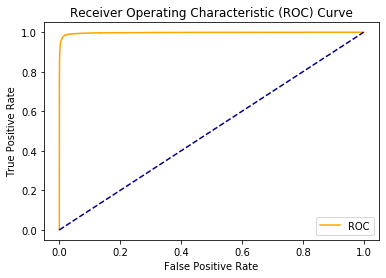

In [22]:
plot_roc_curve(fper, tper)